# SPOT Feature Mapping

### Approach
What are the most important features? Do they correspond to something?
- compare to truecolor and falsecolor
- first: fig -  features(32, 512) x freq with final activation
- then: for select features, get top activations in truecolor and falsecolor

In [339]:
import glob, json,sys, os
import matplotlib.pyplot as plt
import numpy as np
from skimage.measure import block_reduce
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib.lines as lines

In [3]:
root = '/home/jovyan/solar-pv-global-inventory'

In [4]:
sys.path.append(root)

In [6]:
records = glob.glob(os.path.join(root, 'data','spot','crossval','*_record.json'))

### Shallow Features

In [319]:
# get latent spaces into mem

#start with ann and then can try pred
pixel_values = []
latent_values = []
for r in records:
    rec = json.load(open(r,'r'))
    #if rec['P_px']>0:
    key = r.split('/')[-1].split('_')[0]
    fpath=os.path.join(root,'data','spot','crossval',key+'_data.npz')
    loader = np.load(fpath)#
    ann = loader['ann']
    
    ann_red = block_reduce(ann>0, (16,16), np.mean)

    lsl = np.squeeze(loader['lsl'])
    
    # throw out border pix
    lsl = lsl[1:-1,1:-1,:]
    ann_red = ann_red[1:-1,1:-1]
    
    pixel_values.append(ann_red.reshape(1,-1))
    latent_values.append(lsl.reshape(1,-1,32))

In [320]:
pixel_stack = np.stack(np.squeeze(pixel_values))

In [321]:
latent_stack = np.stack(np.squeeze(latent_values))

In [322]:
data = []
for ii in range(latent_stack.shape[-1]):
    data.append(latent_stack[pixel_stack>0.1,ii])

In [323]:
means = [np.mean(data[ii]) for ii in range(len(data))]

In [274]:
#fig, axs = plt.subplots(1,1,figsize=(30,15))
#axs.boxplot(sorted(data, key=np.mean), vert=False,whis=[0,100],patch_artist=True, medianprops = dict(linestyle='-', linewidth=1, color='firebrick'))
#axs.set_yticklabels([str(el) for el in np.argsort(means)])
#axs.set_xlim([0,None])
#plt.show()

In [324]:
skip_dict = {
    10:[993, 400,1261,851,448, 891, 400, 1380,1140,474],
    1:[1273,93,133,430, 1197, 1220,888,204,546,911,1278,254,1320,536,269],
    24:[ 546,  204,  269,   93,  133, 1273,  430, 1197,1220 , 888,551  ,860 , 430 ,  133 , 204,1360,522,551,1197,317,888,254],
    16:[430,888,404,1220,1197,1273,254,93,482,701,204,546,911],
    26:[448,851],
}

In [325]:
def get_samples(ft_ii, n, skip_dict):
    ft_max_by_sample = latent_stack[...,ft_ii].max(axis=1)

    max_inds = np.argpartition(ft_max_by_sample, -(n+len(skip_dict[ft_ii])))[-(n+len(skip_dict[ft_ii])):]
    print (max_inds)
    latent_samples = latent_stack[max_inds,:,ft_ii]
    pix_coords = []
    for ii in range(n+len(skip_dict[ft_ii])):
        pix_coords.append(( max_inds[ii],latent_samples[ii,:].argmax()//30, latent_samples[ii,:].argmax()%30))
    print (pix_coords)
    
    tc_samples = []
    fc_samples = []
    
    ii=0
    done=0
    while done<n:
        print (ii, done)
        if max_inds[ii] in skip_dict[ft_ii]:
            ii+=1
        else:
            #axs[done,0].imshow(latent_samples[ii,:].reshape(30,30))
            tile = records[max_inds[ii]].split('/')[-1].split('_')[0]
            loader = np.load(os.path.join(root,'data','spot','crossval',tile+'_data.npz'))
            arr = loader['arr']
            tc_samples.append(arr[(pix_coords[ii][1]+1)*16:(pix_coords[ii][1]+2)*16,(pix_coords[ii][2]+1)*16:(pix_coords[ii][2]+2)*16,0:3])
            fc_samples.append(arr[(pix_coords[ii][1]+1)*16:(pix_coords[ii][1]+2)*16,(pix_coords[ii][2]+1)*16:(pix_coords[ii][2]+2)*16,[0,1,3]])
            print (records[max_inds[ii]], pix_coords[ii], ii)
            ii+=1
            done+=1
            
    return tc_samples, fc_samples
            

In [326]:
lsl_samples = {}
for ft_ii in [10,1,24,16,26]:
    lsl_samples[ft_ii] = get_samples(ft_ii,10,skip_dict) ## ruh roh with edges...

[1059  125 1276  474  275  851 1056  519  856  719  682  301  357  955
  987 1201  665 1376  703  427]
[(1059, 2, 13), (125, 28, 15), (1276, 1, 29), (474, 13, 9), (275, 19, 16), (851, 10, 8), (1056, 2, 1), (519, 4, 29), (856, 25, 13), (719, 24, 16), (682, 4, 15), (301, 19, 29), (357, 27, 10), (955, 25, 6), (987, 13, 3), (1201, 2, 0), (665, 18, 6), (1376, 5, 15), (703, 19, 22), (427, 27, 0)]
0 0
/home/jovyan/solar-pv-global-inventory/data/spot/crossval/512:0:1.5:18:-137:5685_record.json (1059, 2, 13) 0
1 1
/home/jovyan/solar-pv-global-inventory/data/spot/crossval/512:0:1.5:18:-137:5686_record.json (125, 28, 15) 1
2 2
/home/jovyan/solar-pv-global-inventory/data/spot/crossval/512:0:1.5:32:-77:7674_record.json (1276, 1, 29) 2
3 3
4 3
/home/jovyan/solar-pv-global-inventory/data/spot/crossval/512:0:1.5:04:-79:3153_record.json (275, 19, 16) 4
5 4
6 4
/home/jovyan/solar-pv-global-inventory/data/spot/crossval/512:0:1.5:11:-193:4927_record.json (1056, 2, 1) 6
7 5
/home/jovyan/solar-pv-global-inv

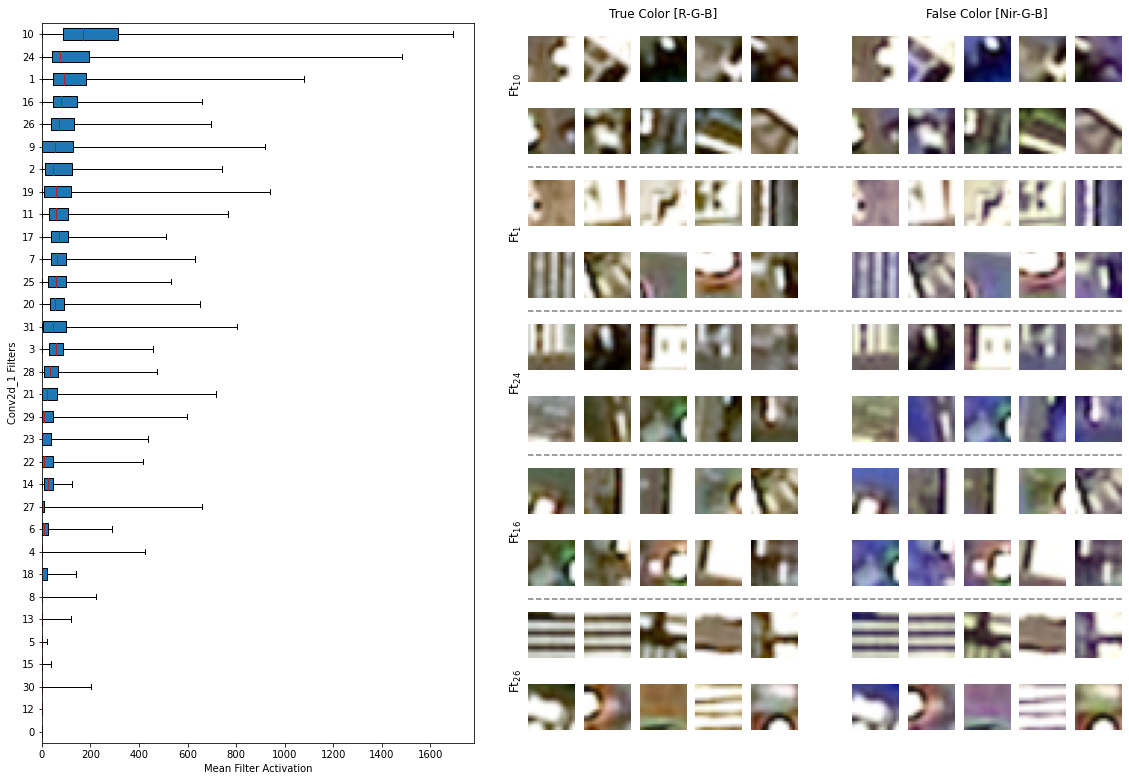

In [350]:
fig = plt.figure(figsize=(15,10))
gs1 = GridSpec(1, 1, left=0, right=0.4, top=1, bottom=0, figure=fig)
gs2 = GridSpec(5,2, left=0.45, right=1, top=1, bottom=0, figure=fig)

axs = {}
gss = {}
axs['TC']={}
axs['FC']={}

for ii in range(5):
    axs['TC'][ii]={}
    axs['FC'][ii]={}
    
    gss[ii] = {}
    gss[ii]['TC'] = GridSpec(2, 5, left=0.45, right=0.7, top=(ii+1)/5, bottom=ii/5, figure=fig, hspace=0)
    gss[ii]['FC'] = GridSpec(2,5, left=0.75, right=1,top=(ii+1)/5, bottom=ii/5, figure=fig, hspace=0)
    
    for jj in range(10):
        axs['TC'][ii][jj] = fig.add_subplot(gss[ii]['TC'][jj//5,jj%5])
        axs['FC'][ii][jj] = fig.add_subplot(gss[ii]['FC'][jj//5,jj%5])


axs['boxplot'] = fig.add_subplot(gs1[0,0])
for ii in range(10):
    axs[ii] = fig.add_subplot(gs2[ii%5,ii//5])
    

axs['boxplot'].boxplot(sorted(data, key=np.mean), vert=False,whis=[0,100],patch_artist=True, medianprops = dict(linestyle='-', linewidth=1, color='firebrick'))
axs['boxplot'].set_yticklabels([str(el) for el in np.argsort(means)])
axs['boxplot'].set_xlim([0,None])
axs['boxplot'].set_xlabel('Mean Filter Activation')
axs['boxplot'].set_ylabel('Conv2d_1 Filters')

for ii_k, (kk,vv) in enumerate(lsl_samples.items()):
    for jj, im  in enumerate(vv[0]): # TC
        axs['TC'][ii_k][jj].imshow(im)
        axs['TC'][ii_k][jj].axis('off')
        
    for jj, im in enumerate(vv[1]): # FC
        axs['FC'][ii_k][jj].imshow(im)
        axs['FC'][ii_k][jj].axis('off')
        
for ii in range(10):
    # make xaxis invisible
    axs[ii].xaxis.set_visible(False)
    # make spines (the box) invisible
    plt.setp(axs[ii].spines.values(), visible=False)
    # remove ticks and labels for the left axis
    axs[ii].tick_params(left=False, labelleft=False)
    #remove background patch (only needed for non-white background)
    axs[ii].patch.set_visible(False)

for ii,kk in zip([0,1,2,3,4],list(lsl_samples.keys())):
    axs[ii].set_ylabel('Ft$_{{{}}}$'.format(kk), fontsize='large')
    

add_lines = []  
for ii in [0.2,0.4,0.6,0.8]:
    add_lines.append(lines.Line2D([.45, 1], [ii, ii], transform=fig.transFigure, figure=fig, color='gray',linestyle='--'))

fig.lines.extend(add_lines)
    
    
axs[0].set_title('True Color [R-G-B]')
axs[5].set_title('False Color [Nir-G-B]')


plt.savefig(os.path.join(root,'solarpv','analysis','low_ft_activations.png'))
plt.show()

### Get deep features

In [351]:
# get latent spaces into mem

#start with ann and then can try pred
pixel_values = []
latent_values = []
for r in records:
    rec = json.load(open(r,'r'))
    #if rec['P_px']>0:
    key = r.split('/')[-1].split('_')[0]
    fpath=os.path.join(root,'data','spot','crossval',key+'_data.npz')
    loader = np.load(fpath)#
    ann = loader['ann']
    
    ann_red = block_reduce(ann>0, (16,16), np.mean)

    lsh = np.squeeze(loader['lsh'])
    
    # throw out border pix
    lsh = lsh[1:-1,1:-1,:]
    ann_red = ann_red[1:-1,1:-1]
    
    pixel_values.append(ann_red.reshape(1,-1))
    latent_values.append(lsh.reshape(1,-1,512))

In [352]:
pixel_stack = np.stack(np.squeeze(pixel_values))

In [353]:
latent_stack = np.stack(np.squeeze(latent_values))

In [354]:
latent_stack.shape

(1384, 900, 512)

In [355]:
data_lsh = []
for ii in range(latent_stack.shape[-1]):
    data_lsh.append(latent_stack[pixel_stack>0.1,ii])

In [356]:
means_lsh = [np.mean(data_lsh[ii]) for ii in range(len(data_lsh))]

In [357]:
plot_data = sorted(data_lsh, key=np.mean)[0:16] + sorted(data_lsh, key=np.mean)[-16:]

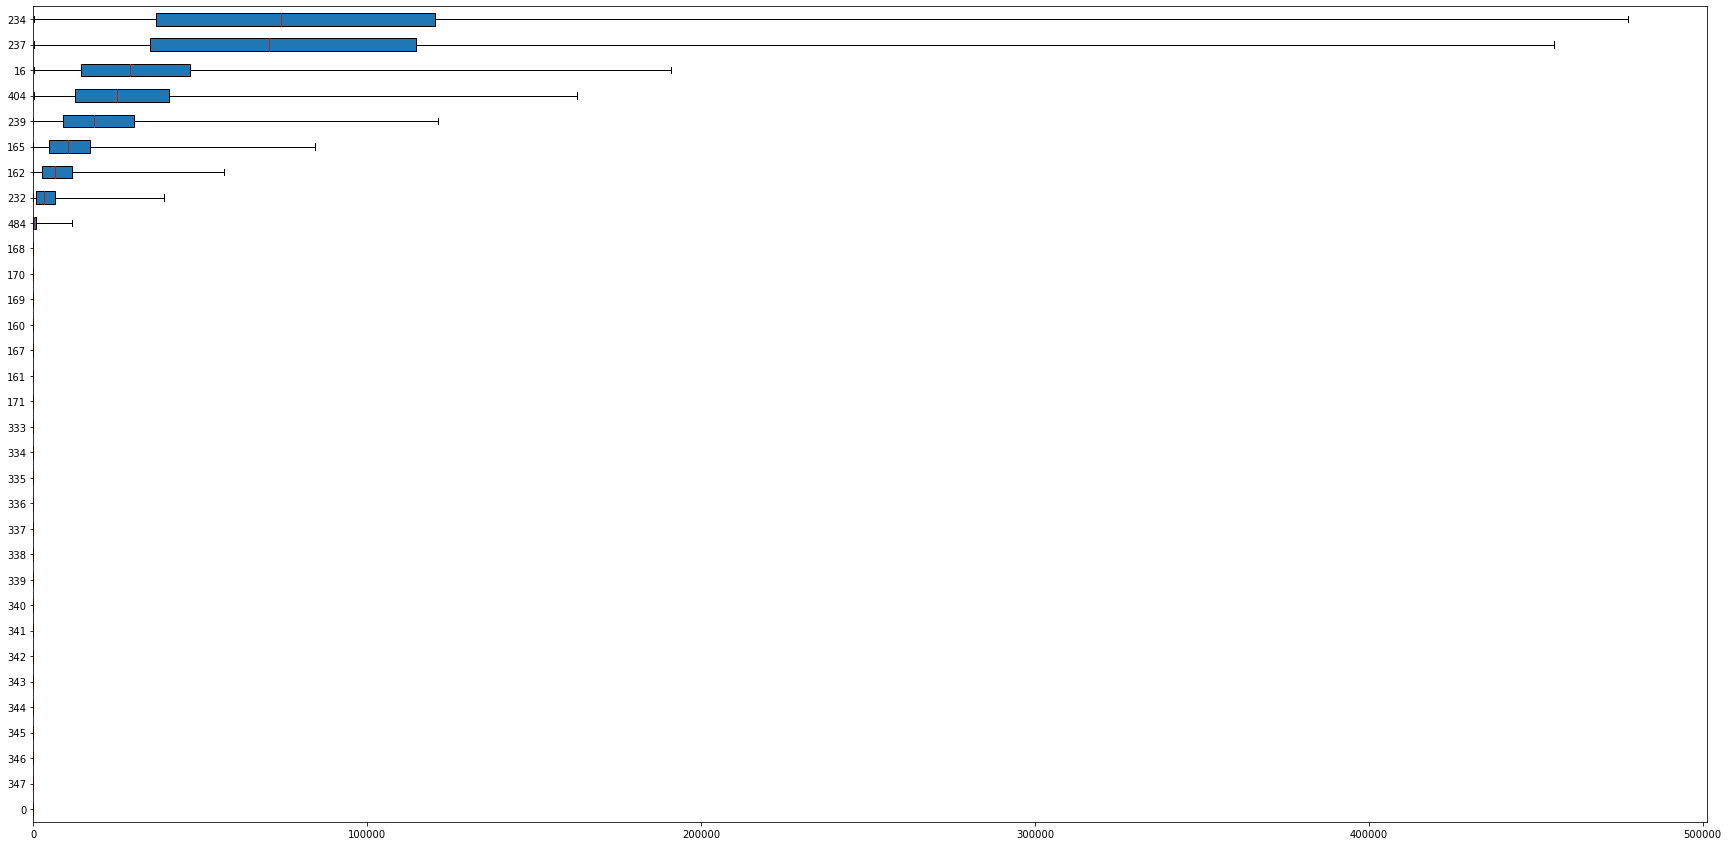

In [302]:
fig, axs = plt.subplots(1,1,figsize=(30,15))
axs.boxplot(plot_data, vert=False,whis=[0,100],patch_artist=True, medianprops = dict(linestyle='-', linewidth=1, color='firebrick'))
axs.set_yticklabels(list(np.argsort(means_lsh)[0:16]) + list(np.argsort(means_lsh)[-16:]))
axs.set_xlim([0,None])
plt.show()

In [358]:
skip_dict = {
    234:[],
    237:[],
    16:[],
    404:[],
    239:[]
}

In [359]:
def get_samples(ft_ii, n, skip_dict):
    ft_max_by_sample = latent_stack[...,ft_ii].max(axis=1)

    max_inds = np.argpartition(ft_max_by_sample, -(n+len(skip_dict[ft_ii])))[-(n+len(skip_dict[ft_ii])):]
    print (max_inds)
    latent_samples = latent_stack[max_inds,:,ft_ii]
    pix_coords = []
    for ii in range(n+len(skip_dict[ft_ii])):
        pix_coords.append(( max_inds[ii],latent_samples[ii,:].argmax()//30, latent_samples[ii,:].argmax()%30))
    print (pix_coords)
    
    tc_samples = []
    fc_samples = []
    
    #fig, axs = plt.subplots(n, 3, figsize=(30,20))
    
    ii=0
    done=0
    while done<n:
        print (ii, done)
        if max_inds[ii] in skip_dict[ft_ii]:
            ii+=1
        else:
            #axs[done,0].imshow(latent_samples[ii,:].reshape(30,30))
            tile = records[max_inds[ii]].split('/')[-1].split('_')[0]
            loader = np.load(os.path.join(root,'data','spot','crossval',tile+'_data.npz'))
            arr = loader['arr']
            #axs[done,1].imshow(arr[(pix_coords[ii][1]+1)*16:(pix_coords[ii][1]+2)*16,(pix_coords[ii][2]+1)*16:(pix_coords[ii][2]+2)*16,0:3])
            #axs[done,2].imshow(arr[(pix_coords[ii][1]+1)*16:(pix_coords[ii][1]+2)*16,(pix_coords[ii][2]+1)*16:(pix_coords[ii][2]+2)*16,[0,1,3]])
            
            tc_samples.append(arr[(pix_coords[ii][1]+1)*16:(pix_coords[ii][1]+2)*16,(pix_coords[ii][2]+1)*16:(pix_coords[ii][2]+2)*16,0:3])
            fc_samples.append(arr[(pix_coords[ii][1]+1)*16:(pix_coords[ii][1]+2)*16,(pix_coords[ii][2]+1)*16:(pix_coords[ii][2]+2)*16,[0,1,3]])
            print (records[max_inds[ii]], pix_coords[ii], ii)
            ii+=1
            done+=1
            
    #plt.show()
    return tc_samples, fc_samples

In [360]:
lsh_samples = {}
for ii in [234, 237, 16, 404, 239]:
    lsh_samples[ii] = get_samples(ii, 10, skip_dict)

[810 614 577 800 668 734 169 969 669 587]
[(810, 6, 27), (614, 20, 5), (577, 18, 22), (800, 20, 8), (668, 14, 27), (734, 19, 16), (169, 10, 24), (969, 6, 3), (669, 12, 2), (587, 26, 26)]
0 0
/home/jovyan/solar-pv-global-inventory/data/spot/crossval/512:0:1.5:11:-173:5014_record.json (810, 6, 27) 0
1 1
/home/jovyan/solar-pv-global-inventory/data/spot/crossval/512:0:1.5:11:-170:5020_record.json (614, 20, 5) 1
2 2
/home/jovyan/solar-pv-global-inventory/data/spot/crossval/512:0:1.5:11:-173:5019_record.json (577, 18, 22) 2
3 3
/home/jovyan/solar-pv-global-inventory/data/spot/crossval/512:0:1.5:11:-171:5020_record.json (800, 20, 8) 3
4 4
/home/jovyan/solar-pv-global-inventory/data/spot/crossval/512:0:1.5:11:-172:5013_record.json (668, 14, 27) 4
5 5
/home/jovyan/solar-pv-global-inventory/data/spot/crossval/512:0:1.5:11:-172:5020_record.json (734, 19, 16) 5
6 6
/home/jovyan/solar-pv-global-inventory/data/spot/crossval/512:0:1.5:11:-172:5019_record.json (169, 10, 24) 6
7 7
/home/jovyan/solar-pv

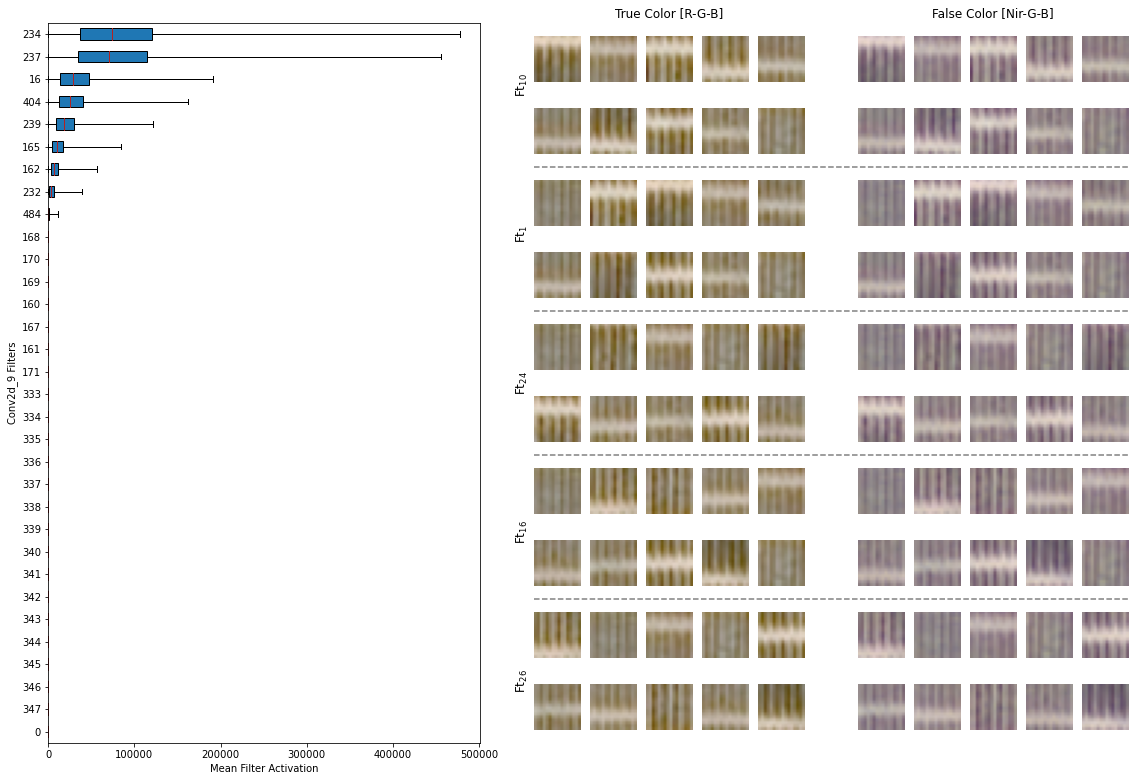

In [362]:
fig = plt.figure(figsize=(15,10))
gs1 = GridSpec(1, 1, left=0, right=0.4, top=1, bottom=0, figure=fig)
gs2 = GridSpec(5,2, left=0.45, right=1, top=1, bottom=0, figure=fig)

axs = {}
gss = {}
axs['TC']={}
axs['FC']={}

for ii in range(5):
    axs['TC'][ii]={}
    axs['FC'][ii]={}
    
    gss[ii] = {}
    gss[ii]['TC'] = GridSpec(2, 5, left=0.45, right=0.7, top=(ii+1)/5, bottom=ii/5, figure=fig, hspace=0)
    gss[ii]['FC'] = GridSpec(2,5, left=0.75, right=1,top=(ii+1)/5, bottom=ii/5, figure=fig, hspace=0)
    
    for jj in range(10):
        axs['TC'][ii][jj] = fig.add_subplot(gss[ii]['TC'][jj//5,jj%5])
        axs['FC'][ii][jj] = fig.add_subplot(gss[ii]['FC'][jj//5,jj%5])


axs['boxplot'] = fig.add_subplot(gs1[0,0])
for ii in range(10):
    axs[ii] = fig.add_subplot(gs2[ii%5,ii//5])
    

axs['boxplot'].boxplot(plot_data, vert=False,whis=[0,100],patch_artist=True, medianprops = dict(linestyle='-', linewidth=1, color='firebrick'))
axs['boxplot'].set_yticklabels(list(np.argsort(means_lsh)[0:16]) + list(np.argsort(means_lsh)[-16:]))
axs['boxplot'].set_xlim([0,None])
axs['boxplot'].set_xlabel('Mean Filter Activation')
axs['boxplot'].set_ylabel('Conv2d_9 Filters')

for ii_k, (kk,vv) in enumerate(lsh_samples.items()):
    for jj, im  in enumerate(vv[0]): # TC
        axs['TC'][ii_k][jj].imshow(im)
        axs['TC'][ii_k][jj].axis('off')
        
    for jj, im in enumerate(vv[1]): # FC
        axs['FC'][ii_k][jj].imshow(im)
        axs['FC'][ii_k][jj].axis('off')
        
for ii in range(10):
    # make xaxis invisible
    axs[ii].xaxis.set_visible(False)
    # make spines (the box) invisible
    plt.setp(axs[ii].spines.values(), visible=False)
    # remove ticks and labels for the left axis
    axs[ii].tick_params(left=False, labelleft=False)
    #remove background patch (only needed for non-white background)
    axs[ii].patch.set_visible(False)

for ii,kk in zip([0,1,2,3,4],list(lsl_samples.keys())):
    axs[ii].set_ylabel('Ft$_{{{}}}$'.format(kk), fontsize='large')
    

add_lines = []  
for ii in [0.2,0.4,0.6,0.8]:
    add_lines.append(lines.Line2D([.45, 1], [ii, ii], transform=fig.transFigure, figure=fig, color='gray',linestyle='--'))

fig.lines.extend(add_lines)
    
    
axs[0].set_title('True Color [R-G-B]')
axs[5].set_title('False Color [Nir-G-B]')


plt.savefig(os.path.join(root,'solarpv','analysis','high_ft_activations.png'))
plt.show()

In [92]:
a = np.array([[3,13,1,9],[11,2,5,12],[2,4,15,0]])

In [93]:
a

array([[ 3, 13,  1,  9],
       [11,  2,  5, 12],
       [ 2,  4, 15,  0]])

In [94]:
inds = a.argmax()//a.shape[1], a.argmax()%a.shape[1]

In [95]:
inds

(2, 2)

In [96]:
a[inds[0], inds[1]]

15